In [1]:
import pandas as pd
import numpy as np
from os.path import basename
from glob import glob
import h5py

import scipy.stats as ss
from sklearn.metrics import r2_score, average_precision_score, roc_auc_score

import matplotlib.pyplot as plt
from plotnine import *
from IPython.display import display, Markdown

import sys
sys.path.insert(0, '../CODE/')
from importlib import reload
import visualization_utils
reload(visualization_utils)
from visualization_utils import *

import warnings
warnings.filterwarnings('ignore')

## Yeast S288C data

In [2]:
## Yeast gene name mapping
yeast_name_dict = {x: y for x, y in np.loadtxt('../RESOURCES/Yeast_genome/orf_name_conversion.tab', dtype='str')}

### Fig. 1C: Model accuracy on yeast TFs using all binding location data

In [3]:
feat_types = ['all_feats']

stats_arr = []

## Calling cards vs ZEV using RF classifier
algo = 'rf'
dirpath = '../OUTPUT/Yeast_cc_zev'
stats = parse_classifier_stats(dirpath, algo, feat_types, yeast_name_dict)
stats['algorithm'] = algo
stats['tfb'] = 'Calling cards'
stats_arr.append(stats)

## Calling cards vs ZEV using XGBoost classifier
algo = 'xgb'
dirpath = '../OUTPUT/Yeast_cc_zev'
stats = parse_classifier_stats(dirpath, algo, feat_types, yeast_name_dict)
stats['algorithm'] = algo
stats['tfb'] = 'Calling cards'
stats_arr.append(stats)

## ChIPexo vs ZEV using RF classifier
algo = 'rf'
dirpath = '../OUTPUT/Yeast_chipexo_zev'
stats = parse_classifier_stats(dirpath, algo, feat_types, yeast_name_dict)
stats['algorithm'] = algo
stats['tfb'] = 'ChIP-exo'
stats_arr.append(stats)

## ChIPexo vs ZEV using XGBoost classifier
algo = 'xgb'
dirpath = '../OUTPUT/Yeast_chipexo_zev'
stats = parse_classifier_stats(dirpath, algo, feat_types, yeast_name_dict)
stats['algorithm'] = algo
stats['tfb'] = 'ChIP-exo'
stats_arr.append(stats)

stats_df = pd.concat(stats_arr)

... working on all_feats
... working on all_feats
... working on all_feats
... working on all_feats


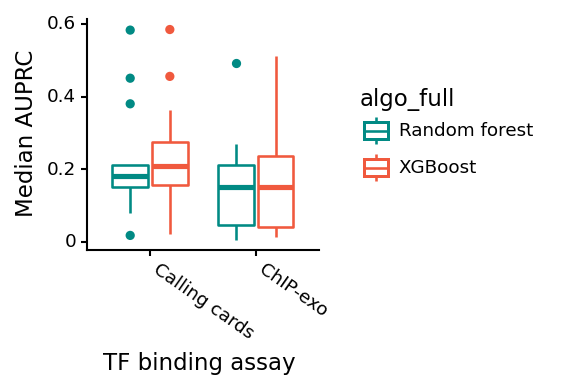

<ggplot: (-9223372029842877019)>

In [4]:
## Calculate AUC of median fold for each TF model
med_df = stats_df.groupby(['tf', 'tfb', 'algorithm'])[['auprc']].median().reset_index()
med_df.loc[med_df['algorithm'] == 'rf', 'algo_full'] = 'Random forest'
med_df.loc[med_df['algorithm'] == 'xgb', 'algo_full'] = 'XGBoost'

## Plot boxplots
ax = (
    ggplot(med_df, aes(x='tfb', y='auprc', color='algo_full'))
    + geom_boxplot(size=.7)
    + scale_color_manual(values=[COLORS['dark_green'], COLORS['orange']])
    + xlab('TF binding assay')
    + ylab('Median AUPRC')
    + theme_classic()
    + theme(figure_size=(2, 2), dpi=150,
           axis_text_x=element_text(angle=-35, hjust=0, color='#000000'),
           axis_text_y=element_text(color='#000000'))
)
display(ax)

### Fig. 1D: Model accuracy on eight yeast TFs with binding location data from both ChIP-exo and calling cards assays

In [5]:
feat_types = ['all_feats']
algo = 'xgb' ## All using XGBoost classifier

stats_arr = []

## Calling cards vs ZEV
dirpath = '../OUTPUT/Yeast_cc_zev'
stats = parse_classifier_stats(dirpath, algo, feat_types, yeast_name_dict)
stats['tfb'] = 'Calling cards'
stats_arr.append(stats)

## ChIPexo vs ZEV
dirpath = '../OUTPUT/Yeast_chipexo_zev'
stats = parse_classifier_stats(dirpath, algo, feat_types, yeast_name_dict)
stats['tfb'] = 'ChIP-exo'
stats_arr.append(stats)

## Binding potentials vs ZEV
dirpath = '../OUTPUT/Yeast_bp_zev'
stats = parse_classifier_stats(dirpath, algo, feat_types, yeast_name_dict)
stats['tfb'] = 'Binding potentials'
stats_arr.append(stats)

stats_df = pd.concat(stats_arr)
stats_df['tfb'] = pd.Categorical(
    stats_df['tfb'], ordered=True,
    categories=['Binding potentials', 'ChIP-exo', 'Calling cards'])

... working on all_feats
... working on all_feats
... working on all_feats


In [6]:
## Get common yeast TFs 
common_yeast_tfs = np.intersect1d(
    np.loadtxt('../RESOURCES/Yeast_CallingCards_TFs.txt', dtype=str),
    np.loadtxt('../RESOURCES/Yeast_ChIPexo_TFs.txt', dtype=str))
common_yeast_tfs = ['{} ({})'.format(x, yeast_name_dict[x]) for x in common_yeast_tfs]

print('Common yeast TFs (n={}): {}'.format(len(common_yeast_tfs), common_yeast_tfs))

Common yeast TFs (n=8): ['YEL009C (GCN4)', 'YJR060W (CBF1)', 'YKL038W (RGT1)', 'YLR451W (LEU3)', 'YNL199C (GCR2)', 'YOL108C (INO4)', 'YOR344C (TYE7)', 'YPL075W (GCR1)']


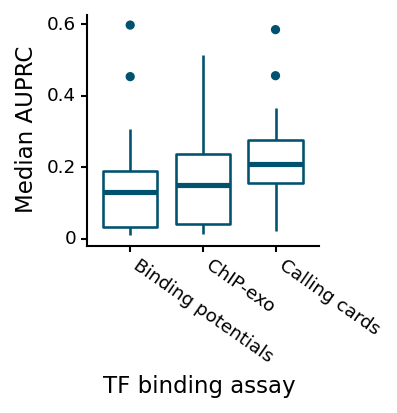

<ggplot: (7012618374)>

In [7]:
## Calculate AUC of median fold for each TF model
med_df = stats_df.groupby(['tf', 'tfb'])[['auprc']].median().reset_index()

## Plot boxplots
ax = (
    ggplot(med_df, aes(x='tfb', y='auprc'))
    + geom_boxplot(color=COLORS['dark_blue'], size=.7)
    + xlab('TF binding assay')
    + ylab('Median AUPRC')
    + theme_classic()
    + theme(
        figure_size=(2, 2), dpi=150,
           axis_text_x=element_text(angle=-35, hjust=0, color='#000000'),
           axis_text_y=element_text(color='#000000'))
)
display(ax)

### Fig. 2D: Comparison of yeast model accuracy using four types of input features
1. Full model
2. The model trained without TF binding features
3. The model without gene expression features
4. The model without histone marks (HMs)

In [8]:
algo = 'xgb'

stats_arr = []

## Calling cards: Full model
dirpath = '../OUTPUT/Yeast_cc_zev'
feat_types = ['all_feats']
stats = parse_classifier_stats(dirpath, algo, feat_types, yeast_name_dict)
stats['tfb'] = 'Calling cards'
stats['model_type'] = 'Full model'
stats_arr.append(stats)

## Calling cards: Excl. TF binding
dirpath = '../OUTPUT/Yeast_cc_zev'
feat_types = ['dna_hm_atac_expr']
stats = parse_classifier_stats(dirpath, algo, feat_types, yeast_name_dict)
stats['tfb'] = 'Calling cards'
stats['model_type'] = 'Excl. TF binding'
stats_arr.append(stats)

## Calling cards: Excl. GEX
dirpath = '../OUTPUT/Yeast_cc_zev'
feat_types = ['tfb_hm_atac_dna']
stats = parse_classifier_stats(dirpath, algo, feat_types, yeast_name_dict)
stats['tfb'] = 'Calling cards'
stats['model_type'] = 'Excl. GEX'
stats_arr.append(stats)

## Calling cards: Excl. HMs
dirpath = '../OUTPUT/Yeast_cc_zev'
feat_types = ['dna_tfb_atac_expr']
stats = parse_classifier_stats(dirpath, algo, feat_types, yeast_name_dict)
stats['tfb'] = 'Calling cards'
stats['model_type'] = 'Excl. HMs'
stats_arr.append(stats)

## --------------------
## ChIP-exo: Full model
dirpath = '../OUTPUT/Yeast_chipexo_zev'
feat_types = ['all_feats']
stats = parse_classifier_stats(dirpath, algo, feat_types, yeast_name_dict)
stats['tfb'] = 'ChIP-exo'
stats['model_type'] = 'Full model'
stats_arr.append(stats)

## ChIP-exo: Excl. TF binding
dirpath = '../OUTPUT/Yeast_chipexo_zev'
feat_types = ['dna_hm_atac_expr']
stats = parse_classifier_stats(dirpath, algo, feat_types, yeast_name_dict)
stats['tfb'] = 'ChIP-exo'
stats['model_type'] = 'Excl. TF binding'
stats_arr.append(stats)

## ChIP-exo: Excl. GEX
dirpath = '../OUTPUT/Yeast_chipexo_zev'
feat_types = ['tfb_hm_atac_dna']
stats = parse_classifier_stats(dirpath, algo, feat_types, yeast_name_dict)
stats['tfb'] = 'ChIP-exo'
stats['model_type'] = 'Excl. GEX'
stats_arr.append(stats)

## ChIP-exo: Excl. HMs
dirpath = '../OUTPUT/Yeast_chipexo_zev'
feat_types = ['dna_tfb_atac_expr']
stats = parse_classifier_stats(dirpath, algo, feat_types, yeast_name_dict)
stats['tfb'] = 'ChIP-exo'
stats['model_type'] = 'Excl. HMs'
stats_arr.append(stats)

stats_df = pd.concat(stats_arr)
model_types = ['Full model', 'Excl. TF binding', 'Excl. GEX', 'Excl. HMs']
stats_df['model_type'] = pd.Categorical(
    stats_df['model_type'], ordered=True, 
    categories=model_types)

... working on all_feats
... working on dna_hm_atac_expr
... working on tfb_hm_atac_dna
... working on dna_tfb_atac_expr
... working on all_feats
... working on dna_hm_atac_expr
... working on tfb_hm_atac_dna
... working on dna_tfb_atac_expr


,Model x,Model y,Median AUC x,Median AUC y,Median diff (x-y),Avg AUC x,Avg AUC y,Avg diff (x-y),Pval (paired t-test)
0,Full model,Excl. TF binding,0.161352,0.121230,0.040122,0.19327,0.141142,0.052128,0.000502
1,Full model,Excl. GEX,0.161352,0.159735,0.001617,0.19327,0.174684,0.018585,0.000209
2,Full model,Excl. HMs,0.161352,0.167794,-0.006442,0.19327,0.183489,0.009781,0.039365


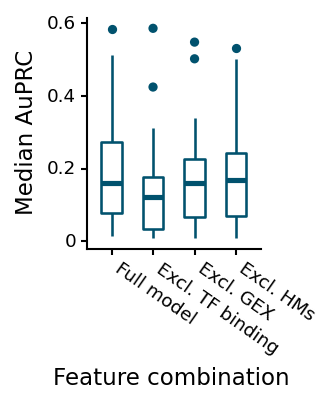

<ggplot: (7012659120)>

In [9]:
## Calculate AUC of median fold for each TF model
med_df = stats_df.groupby(['tf', 'tfb', 'model_type'])[['auprc']].median().reset_index()

## Get the best TFB type for each TF
tfb_valid = []
for tf, subdf in med_df[med_df['model_type'] == 'Full model'].groupby('tf'):
    row = subdf.iloc[subdf['auprc'].argmax()]
    tfb_valid.append(row['tf'] + ':' + row['tfb'])

med_df['tf:tfb'] = med_df['tf'] + ':' + med_df['tfb']
med_df2 = med_df[med_df['tf:tfb'].isin(tfb_valid)]

## Add statistics
sum_stats = pd.DataFrame()
for i, model_type in enumerate(model_types[1:]):
    x_aucs = med_df2.loc[med_df2['model_type'] == model_types[0], 'auprc']
    y_aucs = med_df2.loc[med_df2['model_type'] == model_types[i + 1], 'auprc']
    _, p = ss.ttest_rel(x_aucs, y_aucs)
    sum_stats = sum_stats.append(pd.Series({
        'Model x': model_types[0],
        'Model y': model_types[i + 1],
        'Median AUC x': np.median(x_aucs),
        'Median AUC y': np.median(y_aucs),
        'Median diff (x-y)': np.median(x_aucs) - np.median(y_aucs),
        'Avg AUC x': np.mean(x_aucs),
        'Avg AUC y': np.mean(y_aucs),
        'Avg diff (x-y)': np.mean(x_aucs) - np.mean(y_aucs),
        'Pval (paired t-test)': p
    }), ignore_index=True)

display(sum_stats[['Model x', 'Model y', 'Median AUC x', 'Median AUC y', 'Median diff (x-y)', 
                   'Avg AUC x', 'Avg AUC y', 'Avg diff (x-y)', 'Pval (paired t-test)']])

## Plot boxplots
ax = (
    ggplot(med_df2, aes(x='model_type', y='auprc'))
    + geom_boxplot(size=.7, width=.5, color=COLORS['dark_blue'])
    + labs(x='Feature combination', y='Median AuPRC')
    + theme_classic()
    + theme(figure_size=(1.5, 2), dpi=150,
           axis_text_x=element_text(angle=-35, hjust=0, color='#000000'),
           axis_text_y=element_text(color='#000000'))
)
display(ax)

---
## Human K562 data

In [2]:
human_name_dict = {
    row['ENSEMBL']: row['HGNC'] \
    for _, row in pd.read_csv(
        '../RESOURCES/induction/hgnc_ensembl.tbl',
        sep='\t'
    ).iterrows()}

In [ ]:
## Human gene name mapping
human_name_dict = {
    row['#ensembl_gene_id']: row['external_gene_name'] \
    for _, row in pd.read_csv(
        '../RESOURCES/Human_genome/genes.protein_coding.BioMart.tbl', 
        sep='\t', usecols=[0, 1]
    ).iterrows()}

### Fig. 1E: Model accuracy on human K562 cells using two methods of aggregating data from enhancers associated with each gene

In [8]:
algo = 'xgb'
feat_types = ['all_feats']

stats_arr = []

## Promoters + binned enhancers
dirpath = '../OUTPUT/Human_ChIPseq_TFpert'
stats = parse_classifier_stats(dirpath, algo, feat_types, human_name_dict)
stats['reg_dna'] = 'prom + bin enhan'
stats_arr.append(stats)

# print(stats)

## Promoters + aggregated enhancers
dirpath = '../OUTPUT/Human_ChIPseq_TFpert'
stats = parse_classifier_stats(dirpath, algo, feat_types, human_name_dict)
stats['reg_dna'] = 'prom + agg enhan'
stats_arr.append(stats)

stats_df = pd.concat(stats_arr)
stats_df['reg_dna'] = pd.Categorical(
    stats_df['reg_dna'], ordered=True, 
    categories=['prom + bin enhan', 'prom + agg enhan'])

... working on all_feats
['../OUTPUT/Human_ChIPseq_TFpert/all_feats/xgb/ENSG00000074219', '../OUTPUT/Human_ChIPseq_TFpert/all_feats/xgb/ENSG00000115816', '../OUTPUT/Human_ChIPseq_TFpert/all_feats/xgb/ENSG00000144161', '../OUTPUT/Human_ChIPseq_TFpert/all_feats/xgb/ENSG00000141568', '../OUTPUT/Human_ChIPseq_TFpert/all_feats/xgb/ENSG00000105698', '../OUTPUT/Human_ChIPseq_TFpert/all_feats/xgb/ENSG00000172273', '../OUTPUT/Human_ChIPseq_TFpert/all_feats/xgb/ENSG00000198176', '../OUTPUT/Human_ChIPseq_TFpert/all_feats/xgb/ENSG00000143390', '../OUTPUT/Human_ChIPseq_TFpert/all_feats/xgb/ENSG00000001167', '../OUTPUT/Human_ChIPseq_TFpert/all_feats/xgb/ENSG00000197905', '../OUTPUT/Human_ChIPseq_TFpert/all_feats/xgb/ENSG00000143379', '../OUTPUT/Human_ChIPseq_TFpert/all_feats/xgb/ENSG00000147421', '../OUTPUT/Human_ChIPseq_TFpert/all_feats/xgb/ENSG00000134138', '../OUTPUT/Human_ChIPseq_TFpert/all_feats/xgb/ENSG00000179348', '../OUTPUT/Human_ChIPseq_TFpert/all_feats/xgb/ENSG00000131931', '../OUTPUT/Hum

In [8]:
# algo = 'xgb'
# feat_types = ['all_feats']

# stats_arr = []

# ## Promoters + binned enhancers
# dirpath = '../OUTPUT/Human_chip_pert_enhanPromo500kbBinned_5primPromo2kb'
# stats = parse_classifier_stats(dirpath, algo, feat_types, human_name_dict)
# stats['reg_dna'] = 'prom + bin enhan'
# stats_arr.append(stats)

# ## Promoters + aggregated enhancers
# dirpath = '../OUTPUT/Human_chip_pert_enhanPromo500kbSingle_5primPromo2kb'
# stats = parse_classifier_stats(dirpath, algo, feat_types, human_name_dict)
# stats['reg_dna'] = 'prom + agg enhan'
# stats_arr.append(stats)

# stats_df = pd.concat(stats_arr)
# stats_df['reg_dna'] = pd.Categorical(
#     stats_df['reg_dna'], ordered=True, 
#     categories=['prom + bin enhan', 'prom + agg enhan'])

... working on all_feats
... working on all_feats


In [9]:
stats_df

,tf,chance,feat_type,cv,auroc,auprc,tf_com,reg_dna
0,ENSG00000074219 (TEAD2),0.237037,all_feats,0,0.847420,0.622782,TEAD2,prom + bin enhan
1,ENSG00000074219 (TEAD2),0.237037,all_feats,1,0.865698,0.649314,TEAD2,prom + bin enhan
2,ENSG00000074219 (TEAD2),0.237037,all_feats,2,0.860050,0.625485,TEAD2,prom + bin enhan
3,ENSG00000074219 (TEAD2),0.237037,all_feats,3,0.868231,0.632483,TEAD2,prom + bin enhan
4,ENSG00000074219 (TEAD2),0.237037,all_feats,4,0.850716,0.616398,TEAD2,prom + bin enhan
...,...,...,...,...,...,...,...,...
385,ENSG00000185591 (SP1),0.190305,all_feats,5,0.838406,0.519231,SP1,prom + agg enhan
386,ENSG00000185591 (SP1),0.190305,all_feats,6,0.821934,0.458400,SP1,prom + agg enhan
387,ENSG00000185591 (SP1),0.190305,all_feats,7,0.834136,0.528871,SP1,prom + agg enhan
388,ENSG00000185591 (SP1),0.190305,all_feats,8,0.829948,0.513734,SP1,prom + agg enhan


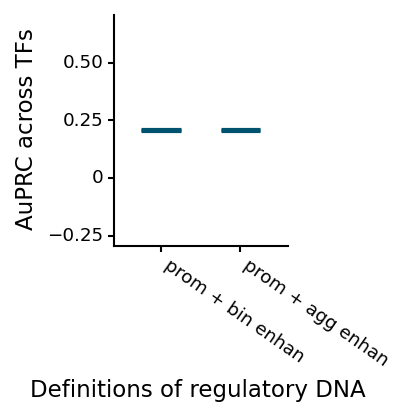

<ggplot: (-9223363265131232887)>

In [10]:
## Calculate AUC of median fold for each TF model
med_df = stats_df.groupby(['feat_type', 'reg_dna'])[['auprc', 'chance']].median().reset_index()

ax = (
    ggplot(
        med_df, 
        aes(x='reg_dna', y='auprc'))
    + geom_boxplot(color=COLORS['dark_blue'], size=.7, width=.5)
    + xlab('Definitions of regulatory DNA')
    + ylab('AuPRC across TFs')
    + theme_classic()
    + theme(figure_size=(1.5, 2), dpi=150,
           axis_text_x=element_text(angle=-35, hjust=0, color='#000000'),
           axis_text_y=element_text(color='#000000'))
)
display(ax)

### Fig. 2F: Comparison of human model accuracy using five types of input features
1. Full model
2. The model trained without TF binding features
3. The model without gene expression features
4. The model without histone marks (HMs)
5. GEX only features

In [3]:
algo = 'xgb'

stats_arr = []

## Full model
dirpath = '../OUTPUT/Human_chip_pert_enhanPromo500kbSingle_5primPromo2kb'
feat_types = ['all_feats']
stats = parse_classifier_stats(dirpath, algo, feat_types, human_name_dict)
stats['model_type'] = 'Full model'
stats_arr.append(stats)

## Excl. TF binding
dirpath = '../OUTPUT/Human_chip_pert_enhanPromo500kbSingle_5primPromo2kb'
feat_types = ['dna_hm_atac_expr']
stats = parse_classifier_stats(dirpath, algo, feat_types, human_name_dict)
stats['model_type'] = 'Excl. TF binding'
stats_arr.append(stats)

## Excl. GEX
dirpath = '../OUTPUT/Human_chip_pert_enhanPromo500kbSingle_5primPromo2kb'
feat_types = ['tfb_hm_atac_dna']
stats = parse_classifier_stats(dirpath, algo, feat_types, human_name_dict)
stats['model_type'] = 'Excl. GEX'
stats_arr.append(stats)

## Excl. HMs
dirpath = '../OUTPUT/Human_chip_pert_enhanPromo500kbSingle_5primPromo2kb'
feat_types = ['dna_tfb_atac_expr']
stats = parse_classifier_stats(dirpath, algo, feat_types, human_name_dict)
stats['model_type'] = 'Excl. HMs'
stats_arr.append(stats)

## GEX only
dirpath = '../OUTPUT/Human_chip_pert_5primGenebody2kb'
feat_types = ['gex']
stats = parse_classifier_stats(dirpath, algo, feat_types, human_name_dict)
stats['model_type'] = 'GEX only'
stats_arr.append(stats)

stats_df = pd.concat(stats_arr)
model_types = ['Full model', 'Excl. TF binding', 'Excl. GEX', 'Excl. HMs', 'GEX only']
stats_df['model_type'] = pd.Categorical(
    stats_df['model_type'], ordered=True, 
    categories=model_types)

... working on all_feats
['../OUTPUT/Human_chip_pert_enhanPromo500kbSingle_5primPromo2kb/all_feats/xgb/ENSG00000074219', '../OUTPUT/Human_chip_pert_enhanPromo500kbSingle_5primPromo2kb/all_feats/xgb/ENSG00000115816', '../OUTPUT/Human_chip_pert_enhanPromo500kbSingle_5primPromo2kb/all_feats/xgb/ENSG00000144161', '../OUTPUT/Human_chip_pert_enhanPromo500kbSingle_5primPromo2kb/all_feats/xgb/ENSG00000141568', '../OUTPUT/Human_chip_pert_enhanPromo500kbSingle_5primPromo2kb/all_feats/xgb/ENSG00000105698', '../OUTPUT/Human_chip_pert_enhanPromo500kbSingle_5primPromo2kb/all_feats/xgb/ENSG00000172273', '../OUTPUT/Human_chip_pert_enhanPromo500kbSingle_5primPromo2kb/all_feats/xgb/ENSG00000198176', '../OUTPUT/Human_chip_pert_enhanPromo500kbSingle_5primPromo2kb/all_feats/xgb/ENSG00000143390', '../OUTPUT/Human_chip_pert_enhanPromo500kbSingle_5primPromo2kb/all_feats/xgb/ENSG00000001167', '../OUTPUT/Human_chip_pert_enhanPromo500kbSingle_5primPromo2kb/all_feats/xgb/ENSG00000197905', '../OUTPUT/Human_chip_pe

KeyboardInterrupt: 

In [6]:
algo = 'xgb'

stats_arr = []

## Full model
dirpath = '../OUTPUT/Human_chip_pert_enhanPromo500kbSingle_5primPromo2kb_CPU'
feat_types = ['all_feats']
stats = parse_classifier_stats(dirpath, algo, feat_types, human_name_dict)
stats['model_type'] = 'Full model'
stats_arr.append(stats)

... working on all_feats
ENSG00000074219
ENSG00000115816
ENSG00000144161
ENSG00000141568
ENSG00000105698
ENSG00000172273
ENSG00000198176
ENSG00000162772
ENSG00000143390
ENSG00000001167
ENSG00000197905
ENSG00000143379
ENSG00000158773
ENSG00000147421
ENSG00000134138
ENSG00000179348
ENSG00000131931
ENSG00000177463
ENSG00000187098
ENSG00000123358
ENSG00000173039
ENSG00000106459
ENSG00000102145
ENSG00000185551
ENSG00000130522
ENSG00000082641
ENSG00000060138
ENSG00000177485
ENSG00000105722
ENSG00000111206
ENSG00000112658
ENSG00000126746
ENSG00000186918
ENSG00000130254
ENSG00000113658
ENSG00000177045
ENSG00000156273
ENSG00000166478
ENSG00000126561
ENSG00000160633
ENSG00000120837
ENSG00000185591


In [7]:
dirpath

'../OUTPUT/Human_chip_pert_enhanPromo500kbSingle_5primPromo2kb_CPU'

In [11]:
subdirs = glob('{}/{}/{}/*'.format(dirpath, 'all_feats', 'xgb'))
subdirs = [basename(subdir) for subdir in subdirs]
print(subdirs)
len(subdirs)

['ENSG00000074219', 'ENSG00000115816', 'ENSG00000144161', 'ENSG00000141568', 'ENSG00000105698', 'ENSG00000172273', 'ENSG00000198176', 'ENSG00000162772', 'ENSG00000143390', 'ENSG00000001167', 'ENSG00000197905', 'ENSG00000143379', 'ENSG00000158773', 'ENSG00000147421', 'ENSG00000134138', 'ENSG00000179348', 'ENSG00000131931', 'ENSG00000177463', 'ENSG00000187098', 'ENSG00000123358', 'ENSG00000173039', 'ENSG00000106459', 'ENSG00000102145', 'ENSG00000185551', 'ENSG00000130522', 'ENSG00000082641', 'ENSG00000060138', 'ENSG00000177485', 'ENSG00000105722', 'ENSG00000111206', 'ENSG00000112658', 'ENSG00000126746', 'ENSG00000186918', 'ENSG00000130254', 'ENSG00000113658', 'ENSG00000177045', 'ENSG00000156273', 'ENSG00000166478', 'ENSG00000126561', 'ENSG00000160633', 'ENSG00000120837', 'ENSG00000185591']


42

In [32]:
stats_df = stats.copy()

In [70]:
mean_auprc = stats_df.groupby(['tf_com'])[['auprc']].mean().reset_index()
mean_auprc

,tf_com,auprc
0,ATF3,0.191845
1,BACH1,0.021593
2,CEBPZ,0.130266
3,ERF,0.423131
4,FOXK2,0.259142
5,FOXM1,0.516711
6,GATA1,0.249528
7,GATA2,0.105820
8,HINFP,0.108909
9,HMBOX1,0.011786


In [34]:
# HGNC --> ENSEMBL MAPPING
ensembl_name_dict = {
    row['HGNC']: row['ENSEMBL'] \
    for _, row in pd.read_csv(
        '../RESOURCES/induction/hgnc_ensembl.tbl',
        sep='\t'
    ).iterrows()}

In [35]:
dict(list(ensembl_name_dict.items())[:10])

{'A1BG': 'ENSG00000121410',
 'A1BG-AS1': 'ENSG00000268895',
 'A1CF': 'ENSG00000148584',
 'A1S9T': nan,
 'A2M': 'ENSG00000175899',
 'A2M-AS1': 'ENSG00000245105',
 'A2ML1': 'ENSG00000166535',
 'A2ML1-AS1': 'ENSG00000256661',
 'A2ML1-AS2': 'ENSG00000256904',
 'A2MP1': 'ENSG00000256069'}

In [36]:
mean_auprc['tf'] = mean_auprc['tf_com'].map(ensembl_name_dict) # new column with ensembl IDs
mean_auprc

,tf_com,auprc,tf
0,ATF3,0.191845,ENSG00000162772
1,BACH1,0.021593,ENSG00000156273
2,CEBPZ,0.130266,ENSG00000115816
3,ERF,0.423131,ENSG00000105722
4,FOXK2,0.259142,ENSG00000141568
5,FOXM1,0.516711,ENSG00000111206
6,GATA1,0.249528,ENSG00000102145
7,GATA2,0.105820,ENSG00000179348
8,HINFP,0.108909,ENSG00000172273
9,HMBOX1,0.011786,ENSG00000147421


In [37]:
mean_auprc[mean_auprc['auprc'] > 0.4].sort_values(by='auprc')

,tf_com,auprc,tf
3,ERF,0.423131,ENSG00000105722
31,TEAD4,0.496063,ENSG00000197905
32,TFDP1,0.503368,ENSG00000198176
27,SP1,0.510361,ENSG00000185591
5,FOXM1,0.516711,ENSG00000111206
12,MITF,0.522859,ENSG00000187098
25,SIX5,0.529870,ENSG00000177045
21,RFX5,0.547443,ENSG00000143390
26,SMAD5,0.551618,ENSG00000113658
10,JUND,0.558427,ENSG00000130522


In [12]:
df = pd.read_csv('../RESOURCES/HumanK562_TFPert/K562_pertResp_DESeq2_long.csv', sep=',')
print(df.head())

  tf_hgnc          tf_ensg        gene_ensg  log2FoldChange      padj
0  ARID3A  ENSG00000116017  ENSG00000000003       -0.013423  0.999934
1  ARID3A  ENSG00000116017  ENSG00000000005        0.005889  0.999934
2  ARID3A  ENSG00000116017  ENSG00000000419        0.015190  0.999934
3  ARID3A  ENSG00000116017  ENSG00000000457       -0.024851  0.999934
4  ARID3A  ENSG00000116017  ENSG00000000460       -0.002384  0.999934


In [13]:
df = df[df['tf_ensg'].isin(subdirs)]
df

,tf_hgnc,tf_ensg,gene_ensg,log2FoldChange,padj
19728,ATF3,ENSG00000162772,ENSG00000186652,-1.227364,1.561967e-49
19729,ATF3,ENSG00000162772,ENSG00000110876,-1.402234,3.473520e-49
19730,ATF3,ENSG00000162772,ENSG00000117984,-0.766997,1.920930e-39
19731,ATF3,ENSG00000162772,ENSG00000161011,-0.788784,3.539923e-38
19732,ATF3,ENSG00000162772,ENSG00000030582,-0.817537,4.903445e-38
...,...,...,...,...,...
1104763,ZNF395,ENSG00000186918,ENSG00000282936,0.120622,1.000000e+00
1104764,ZNF395,ENSG00000186918,ENSG00000283039,0.255575,1.000000e+00
1104765,ZNF395,ENSG00000186918,ENSG00000283071,0.017016,1.000000e+00
1104766,ZNF395,ENSG00000186918,ENSG00000283088,0.000000,1.000000e+00


In [40]:
df[df['gene_ensg']=='ENSG00000105698'].apply(lambda row : 2**row['log2FoldChange'], axis=1).mean()

0.8118196173999918

In [44]:
df_exp = df[['tf_hgnc','tf_ensg','gene_ensg','log2FoldChange']]
df_exp['FoldChange'] = df_exp.apply(lambda row : 2**row['log2FoldChange'], axis=1)
df_exp

,tf_hgnc,tf_ensg,gene_ensg,log2FoldChange,FoldChange
19728,ATF3,ENSG00000162772,ENSG00000186652,-1.227364,0.427097
19729,ATF3,ENSG00000162772,ENSG00000110876,-1.402234,0.378343
19730,ATF3,ENSG00000162772,ENSG00000117984,-0.766997,0.587639
19731,ATF3,ENSG00000162772,ENSG00000161011,-0.788784,0.578832
19732,ATF3,ENSG00000162772,ENSG00000030582,-0.817537,0.567410
...,...,...,...,...,...
1104763,ZNF395,ENSG00000186918,ENSG00000282936,0.120622,1.087204
1104764,ZNF395,ENSG00000186918,ENSG00000283039,0.255575,1.193811
1104765,ZNF395,ENSG00000186918,ENSG00000283071,0.017016,1.011864
1104766,ZNF395,ENSG00000186918,ENSG00000283088,0.000000,1.000000


In [46]:
df_exp['tf_hgnc'].nunique()

42

In [48]:
df_exp_mean = df_exp.groupby(['gene_ensg'])['FoldChange'].mean().reset_index()
df_exp_mean = df_exp_mean[df_exp_mean['gene_ensg'].isin(subdirs)].reset_index(drop=True)
df_exp_mean

,gene_ensg,FoldChange
0,ENSG00000001167,1.129496
1,ENSG00000060138,1.106820
2,ENSG00000074219,0.958971
3,ENSG00000082641,0.846019
4,ENSG00000102145,0.967476
5,ENSG00000105698,0.811820
6,ENSG00000105722,0.817131
7,ENSG00000106459,1.017210
8,ENSG00000111206,1.079822
9,ENSG00000112658,0.907900


In [49]:
df_absexp = df[['tf_hgnc','tf_ensg','gene_ensg','log2FoldChange']]
df_absexp['FoldChange'] = df_absexp.apply(lambda row : 2**abs(row['log2FoldChange']), axis=1)
df_absexp

,tf_hgnc,tf_ensg,gene_ensg,log2FoldChange,FoldChange
19728,ATF3,ENSG00000162772,ENSG00000186652,-1.227364,2.341388
19729,ATF3,ENSG00000162772,ENSG00000110876,-1.402234,2.643106
19730,ATF3,ENSG00000162772,ENSG00000117984,-0.766997,1.701724
19731,ATF3,ENSG00000162772,ENSG00000161011,-0.788784,1.727617
19732,ATF3,ENSG00000162772,ENSG00000030582,-0.817537,1.762395
...,...,...,...,...,...
1104763,ZNF395,ENSG00000186918,ENSG00000282936,0.120622,1.087204
1104764,ZNF395,ENSG00000186918,ENSG00000283039,0.255575,1.193811
1104765,ZNF395,ENSG00000186918,ENSG00000283071,0.017016,1.011864
1104766,ZNF395,ENSG00000186918,ENSG00000283088,0.000000,1.000000


In [64]:
mean_auprc

,tf_com,auprc,tf
0,ATF3,0.191845,ENSG00000162772
1,BACH1,0.021593,ENSG00000156273
2,CEBPZ,0.130266,ENSG00000115816
3,ERF,0.423131,ENSG00000105722
4,FOXK2,0.259142,ENSG00000141568
5,FOXM1,0.516711,ENSG00000111206
6,GATA1,0.249528,ENSG00000102145
7,GATA2,0.105820,ENSG00000179348
8,HINFP,0.108909,ENSG00000172273
9,HMBOX1,0.011786,ENSG00000147421


In [63]:
temp = df_absexp[df_absexp['tf_ensg']==df_absexp['gene_ensg']].reset_index(drop=True)
temp['lfc_post'] = temp.apply(lambda row: np.log2(row['FoldChange']), axis=1)
temp = temp[['tf_hgnc','tf_ensg','lfc_post']]
temp

,tf_hgnc,tf_ensg,lfc_post
0,ATF3,ENSG00000162772,1.219755
1,BACH1,ENSG00000156273,0.950358
2,CEBPZ,ENSG00000115816,0.302977
3,ERF,ENSG00000105722,0.977160
4,FOXK2,ENSG00000141568,0.485458
5,FOXM1,ENSG00000111206,0.292134
6,GATA1,ENSG00000102145,0.971694
7,GATA2,ENSG00000179348,0.313663
8,HINFP,ENSG00000172273,0.416324
9,HMBOX1,ENSG00000147421,0.559082


In [67]:
xx = temp.set_index('tf_ensg').join(mean_auprc[['tf','auprc']].set_index('tf'))
xx

,tf_hgnc,lfc_post,auprc
tf_ensg,,,
ENSG00000162772,ATF3,1.219755,0.191845
ENSG00000156273,BACH1,0.950358,0.021593
ENSG00000115816,CEBPZ,0.302977,0.130266
ENSG00000105722,ERF,0.977160,0.423131
ENSG00000141568,FOXK2,0.485458,0.259142
ENSG00000111206,FOXM1,0.292134,0.516711
ENSG00000102145,GATA1,0.971694,0.249528
ENSG00000179348,GATA2,0.313663,0.105820
ENSG00000172273,HINFP,0.416324,0.108909


In [52]:
df_absexp_mean = df_absexp.groupby(['gene_ensg'])['FoldChange'].max().reset_index()
df_absexp_mean = df_absexp_mean[df_absexp_mean['gene_ensg'].isin(subdirs)].reset_index(drop=True)
df_absexp_mean

,gene_ensg,FoldChange
0,ENSG00000001167,2.600658
1,ENSG00000060138,1.670852
2,ENSG00000074219,5.739702
3,ENSG00000082641,2.710156
4,ENSG00000102145,1.961142
5,ENSG00000105698,4.367274
6,ENSG00000105722,2.236462
7,ENSG00000106459,1.262413
8,ENSG00000111206,1.772407
9,ENSG00000112658,1.754037


In [69]:
df_absexp_mean['lfc_post'] = df_absexp_mean.apply(lambda row: np.log2(row['FoldChange']), axis=1)
df_absexp_mean

,gene_ensg,FoldChange,lfc_post
0,ENSG00000001167,2.600658,1.378877
1,ENSG00000060138,1.670852,0.740584
2,ENSG00000074219,5.739702,2.520976
3,ENSG00000082641,2.710156,1.438376
4,ENSG00000102145,1.961142,0.971694
5,ENSG00000105698,4.367274,2.126733
6,ENSG00000105722,2.236462,1.161218
7,ENSG00000106459,1.262413,0.336184
8,ENSG00000111206,1.772407,0.825710
9,ENSG00000112658,1.754037,0.810679


In [16]:
df_exp_mean_tf = df_exp.groupby(['tf_ensg'])['FoldChange'].mean().reset_index()
df_exp_mean_tf.describe()

,FoldChange
count,42.000000
mean,1.023085
std,0.031123
min,1.000083
25%,1.005102
50%,1.012169
75%,1.031194
max,1.167565


In [17]:
df_exp_med_tf = df_exp.groupby(['tf_ensg'])['FoldChange'].median().reset_index()
df_exp_med_tf.describe()

,FoldChange
count,42.000000
mean,1.004885
std,0.012719
min,0.997627
25%,1.000000
50%,1.000000
75%,1.002126
max,1.059666


In [18]:
df_exp_mean_gene = df_exp.groupby(['gene_ensg'])['FoldChange'].mean().reset_index()
df_exp_mean_gene.describe()

,FoldChange
count,19728.000000
mean,1.023085
std,0.123477
min,0.554721
25%,0.961058
50%,1.011270
75%,1.079665
max,5.790364


In [19]:
df_exp_mean_gene[df_exp_mean_gene['gene_ensg']=='ENSG00000105698']

,gene_ensg,FoldChange
3148,ENSG00000105698,0.81182


In [20]:
df_exp_med_gene = df_exp.groupby(['gene_ensg'])['FoldChange'].median().reset_index()
df_exp_med_gene.describe()

,FoldChange
count,19728.000000
mean,1.000882
std,0.116114
min,0.330383
25%,0.957121
50%,1.000000
75%,1.043158
max,1.756184


## (a) Take absolute value

In [22]:
df_abslfc = df[['tf_hgnc','tf_ensg','gene_ensg','log2FoldChange']]
df_abslfc['abslog2FoldChange'] = df_abslfc['log2FoldChange'].abs()
df_abslfc.head()

,tf_hgnc,tf_ensg,gene_ensg,log2FoldChange,abslog2FoldChange
0,ARID3A,ENSG00000116017,ENSG00000000003,-0.013423,0.013423
1,ARID3A,ENSG00000116017,ENSG00000000005,0.005889,0.005889
2,ARID3A,ENSG00000116017,ENSG00000000419,0.015190,0.015190
3,ARID3A,ENSG00000116017,ENSG00000000457,-0.024851,0.024851
4,ARID3A,ENSG00000116017,ENSG00000000460,-0.002384,0.002384


## (i) take mean (gene_ensg)

In [23]:
df_abslfc_mean = df_abslfc.groupby(['gene_ensg'])['abslog2FoldChange'].mean().reset_index()
df_abslfc_mean = df_abslfc_mean[df_abslfc_mean['gene_ensg'].isin(mean_auprc['tf'])].reset_index(drop=True)
df_abslfc_mean.describe()

,abslog2FoldChange
count,42.000000
mean,0.221424
std,0.100909
min,0.080467
25%,0.161353
50%,0.201864
75%,0.270174
max,0.582812


In [40]:
df_abslfc_mean[df_abslfc_mean['tf_ensg']==ensembl_name_dict['ERF']]

,tf_ensg,abslog2FoldChange
6,ENSG00000105722,0.267527


## (i) take mean (tf_ensg)

In [24]:
df_abslfc_mean = df_abslfc.groupby(['tf_ensg'])['abslog2FoldChange'].mean().reset_index()
df_abslfc_mean = df_abslfc_mean[df_abslfc_mean['tf_ensg'].isin(mean_auprc['tf'])].reset_index(drop=True)
df_abslfc_mean.describe()

,abslog2FoldChange
count,42.000000
mean,0.196865
std,0.097587
min,0.065222
25%,0.125578
50%,0.177984
75%,0.278103
max,0.469725


## (ii) exponentiate, take mean, log2 (gene_ensg)

In [25]:
df_abslfc_exp = df_abslfc.copy()
df_abslfc_exp['FoldChange'] = df_abslfc_exp.apply(lambda row : 2**row['abslog2FoldChange'], axis=1)
df_abslfc_exp_mean = df_abslfc_exp.groupby(['gene_ensg'])['FoldChange'].mean().reset_index()
df_abslfc_exp_mean = df_abslfc_exp_mean[df_abslfc_exp_mean['gene_ensg'].isin(mean_auprc['tf'])].reset_index(drop=True)
df_abslfc_exp_mean.describe()

,FoldChange
count,42.000000
mean,1.188202
std,0.104705
min,1.058585
25%,1.125723
50%,1.167850
75%,1.224501
max,1.616403


## (ii) exponentiate, take mean, log2 (tf_ensg)

In [26]:
df_abslfc_exp_mean_tf = df_abslfc_exp.groupby(['tf_ensg'])['FoldChange'].mean().reset_index()
df_abslfc_exp_mean_tf = df_abslfc_exp_mean_tf[df_abslfc_exp_mean_tf['tf_ensg'].isin(mean_auprc['tf'])].reset_index(drop=True)
df_abslfc_exp_mean_tf.describe()

,FoldChange
count,42.000000
mean,1.167333
std,0.097547
min,1.048405
25%,1.095870
50%,1.142639
75%,1.241749
max,1.472930


## (b) Abs last

## (i) take mean then abs value (gene_ensg)

In [28]:
df_lfc = df[['tf_hgnc','tf_ensg','gene_ensg','log2FoldChange']]
df_lfc_mean = df_lfc.groupby(['gene_ensg'])['log2FoldChange'].mean().reset_index()
df_lfc_mean = df_lfc_mean[df_lfc_mean['gene_ensg'].isin(mean_auprc['tf'])].reset_index(drop=True)
df_lfc_mean.describe()

,log2FoldChange
count,42.000000
mean,-0.053786
std,0.165247
min,-0.470077
25%,-0.159684
50%,-0.063190
75%,0.086679
max,0.213550


## (i) take mean then abs value (tf_ensg)

In [29]:
df_lfc_mean_tf = df_lfc.groupby(['tf_ensg'])['log2FoldChange'].mean().reset_index()
df_lfc_mean_tf = df_lfc_mean_tf[df_lfc_mean_tf['tf_ensg'].isin(mean_auprc['tf'])].reset_index(drop=True)
print(df_lfc_mean_tf.head())
df_lfc_mean_tf.describe()

           tf_ensg  log2FoldChange
0  ENSG00000001167        0.015934
1  ENSG00000060138       -0.000826
2  ENSG00000074219       -0.008601
3  ENSG00000082641        0.070607
4  ENSG00000102145        0.021993


,log2FoldChange
count,42.000000
mean,-0.002491
std,0.022893
min,-0.071112
25%,-0.010776
50%,-0.005502
75%,-0.000166
max,0.070607


## (ii) exponentiate, take mean, take log2, abs value (gene_ensg)

In [30]:
df_lfc_exp = df_lfc.copy()
df_lfc_exp['FoldChange'] = df_lfc_exp.apply(lambda row : 2**row['log2FoldChange'], axis=1)
df_lfc_exp_mean = df_lfc_exp.groupby(['gene_ensg'])['FoldChange'].mean().reset_index()
df_lfc_exp_mean = df_lfc_exp_mean[df_lfc_exp_mean['gene_ensg'].isin(mean_auprc['tf'])].reset_index(drop=True)
df_lfc_exp_mean.describe()

,FoldChange
count,42.000000
mean,0.987547
std,0.105912
min,0.787748
25%,0.910770
50%,0.972166
75%,1.073933
max,1.185698


## (ii) exponentiate, take mean, take log2, abs value (tf_ensg)

In [31]:
df_lfc_exp_mean_tf = df_lfc_exp.groupby(['tf_ensg'])['FoldChange'].mean().reset_index()
df_lfc_exp_mean_tf = df_lfc_exp_mean_tf[df_lfc_exp_mean_tf['tf_ensg'].isin(mean_auprc['tf'])].reset_index(drop=True)
df_lfc_exp_mean_tf.describe()

,FoldChange
count,42.000000
mean,1.023085
std,0.031123
min,1.000083
25%,1.005102
50%,1.012169
75%,1.031194
max,1.167565


In [51]:
df_lfc = df_lfc[df_lfc['gene_ensg'].isin(mean_auprc['tf'])].reset_index()
df_lfc_gt = df_lfc[df_lfc['log2FoldChange'] > 1.5]

,index,gene_ensg,log2FoldChange


,Model x,Model y,Median AUC x,Median AUC y,Median diff (x-y),Avg AUC x,Avg AUC y,Avg diff (x-y),Pval (paired t-test)
0,Full model,Excl. TF binding,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Full model,Excl. GEX,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Full model,Excl. HMs,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Full model,GEX only,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Excl. TF binding,Excl. GEX,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Excl. TF binding,Excl. HMs,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Excl. TF binding,GEX only,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Excl. GEX,Excl. HMs,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Excl. GEX,GEX only,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Excl. HMs,GEX only,NaN,NaN,NaN,NaN,NaN,NaN,NaN


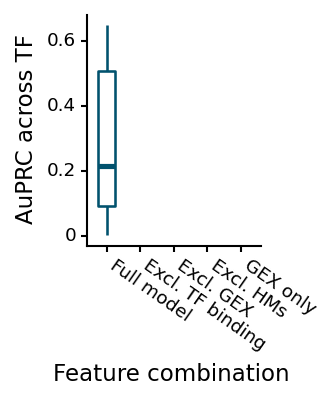

<ggplot: (-9223363265131259055)>

In [13]:
## Calculate AUC of median fold for each TF model
med_df = stats_df.groupby(['model_type', 'tf_com'])[['auprc', 'chance']].median().reset_index()

## Filter for the common TFs (2 of all K562 TFs don't have binding data)
human_tfs = np.loadtxt('../RESOURCES/h5_data/Human_ENCODE_K562_TFs.txt', dtype=str)
tf_cnts = med_df.groupby('tf_com')['tf_com'].count()
human_tfs = tf_cnts[tf_cnts == len(model_types)].index.values
med_df = med_df[med_df['tf_com'].isin(human_tfs)]

## Calculate pairwise statistics
sum_stats = pd.DataFrame()
for i, x in enumerate(model_types):
    for j, y in enumerate(model_types):
        if j <= i:
            continue
        x_aucs = med_df[med_df['model_type'] == x].set_index('tf_com').loc[human_tfs]['auprc']
        y_aucs = med_df[med_df['model_type'] == y].set_index('tf_com').loc[human_tfs]['auprc']
        x_aucs = x_aucs[(~x_aucs.isnull()) & (~y_aucs.isnull())]
        y_aucs = y_aucs[(~x_aucs.isnull()) & (~y_aucs.isnull())]
        _, p = ss.ttest_rel(x_aucs, y_aucs)
        
        sum_stats = sum_stats.append(pd.Series({
            'Model x': x,
            'Model y': y,
            'Median AUC x': np.median(x_aucs),
            'Median AUC y': np.median(y_aucs),
            'Median diff (x-y)': np.median(x_aucs) - np.median(y_aucs),
            'Avg AUC x': np.mean(x_aucs),
            'Avg AUC y': np.mean(y_aucs),
            'Avg diff (x-y)': np.mean(x_aucs) - np.mean(y_aucs),
            'Pval (paired t-test)': p
        }), ignore_index=True)

display(sum_stats[['Model x', 'Model y', 'Median AUC x', 'Median AUC y', 'Median diff (x-y)', 
                   'Avg AUC x', 'Avg AUC y', 'Avg diff (x-y)', 'Pval (paired t-test)']])
        
ax = (
    ggplot(med_df, aes(x='model_type', y='auprc'))
    + geom_boxplot(color=COLORS['dark_blue'], size=.7, width=.5)
    + xlab('Feature combination')
    + ylab('AuPRC across TF')
    + theme_classic()
    + theme(figure_size=(1.5, 2), dpi=150,
           axis_text_x=element_text(color='#000000', angle=-35, hjust=0),
           axis_text_y=element_text(color='#000000'))
)
display(ax)

### Fig. 2H: Comparison of human model accuracy using four types of input features
1. Full model
2. The model excluding enhancer features (Promo only)
3. The model excluding enhancer features and features mapped upstream of the TSS (Gene body 2Kb)
4. The model using only pre-perturbation gene expression features (GEX only)

In [15]:
algo = 'xgb'

stats_arr = []

## Enhan + promo
dirpath = '../OUTPUT/Human_chip_pert_enhanPromo500kbSingle_5primPromo2kb'
feat_types = ['all_feats']
stats = parse_classifier_stats(dirpath, algo, feat_types, human_name_dict)
stats['model_type'] = 'Enhan + promo'
stats_arr.append(stats)

## Promo only
dirpath = '../OUTPUT/Human_chip_pert_5primPromo2kb'
feat_types = ['all_feats']
stats = parse_classifier_stats(dirpath, algo, feat_types, human_name_dict)
stats['model_type'] = 'Promo only'
stats_arr.append(stats)

## Gene body 2kb
dirpath = '../OUTPUT/Human_chip_pert_5primGenebody2kb'
feat_types = ['all_feats']
stats = parse_classifier_stats(dirpath, algo, feat_types, human_name_dict)
stats['model_type'] = 'Gene body 2kb'
stats_arr.append(stats)

## GEX only
dirpath = '../OUTPUT/Human_chip_pert_5primGenebody2kb'
feat_types = ['gex']
stats = parse_classifier_stats(dirpath, algo, feat_types, human_name_dict)
stats['model_type'] = 'GEX only'
stats_arr.append(stats)

stats_df = pd.concat(stats_arr)
model_types = ['Enhan + promo', 'Promo only', 'Gene body 2kb', 'GEX only']
stats_df['model_type'] = pd.Categorical(
    stats_df['model_type'], ordered=True, 
    categories=model_types)

... working on all_feats
... working on all_feats
... working on all_feats
... working on gex


,Model x,Model y,Median AUC x,Median AUC y,Median diff (x-y),Avg AUC x,Avg AUC y,Avg diff (x-y),Pval (paired t-test)
0,Enhan + promo,Promo only,0.179717,0.175965,0.003753,0.257825,0.248935,0.008891,1.395371e-04
1,Enhan + promo,Gene body 2kb,0.179717,0.181503,-0.001786,0.257825,0.250381,0.007444,1.909572e-03
2,Enhan + promo,GEX only,0.179717,0.159750,0.019967,0.257825,0.223283,0.034542,4.413676e-10
3,Promo only,Gene body 2kb,0.175965,0.181503,-0.005538,0.248935,0.250381,-0.001447,2.030124e-02
4,Promo only,GEX only,0.175965,0.159750,0.016214,0.248935,0.223283,0.025651,1.238230e-10
5,Gene body 2kb,GEX only,0.181503,0.159750,0.021753,0.250381,0.223283,0.027098,2.369869e-11


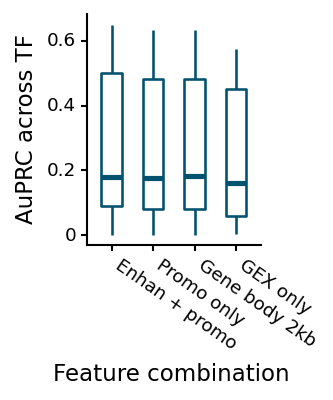

<ggplot: (-9223372029842553596)>

In [16]:
## Calculate AUC of median fold for each TF model
med_df = stats_df.groupby(['model_type', 'tf_com'])[['auprc', 'chance']].median().reset_index()

## Filter for the common TFs (2 of all K562 TFs don't have binding data)
human_tfs = np.loadtxt('../RESOURCES/Human_ENCODE_K562_TFs.txt', dtype=str)
tf_cnts = med_df.groupby('tf_com')['tf_com'].count()
human_tfs = tf_cnts[tf_cnts == len(model_types)].index.values
med_df = med_df[med_df['tf_com'].isin(human_tfs)]

## Calculate pairwise statistics
sum_stats = pd.DataFrame()
for i, x in enumerate(model_types):
    for j, y in enumerate(model_types):
        if j <= i:
            continue
        x_aucs = med_df[med_df['model_type'] == x].set_index('tf_com').loc[human_tfs]['auprc']
        y_aucs = med_df[med_df['model_type'] == y].set_index('tf_com').loc[human_tfs]['auprc']
        x_aucs = x_aucs[(~x_aucs.isnull()) & (~y_aucs.isnull())]
        y_aucs = y_aucs[(~x_aucs.isnull()) & (~y_aucs.isnull())]
        _, p = ss.ttest_rel(x_aucs, y_aucs)
        
        sum_stats = sum_stats.append(pd.Series({
            'Model x': x,
            'Model y': y,
            'Median AUC x': np.median(x_aucs),
            'Median AUC y': np.median(y_aucs),
            'Median diff (x-y)': np.median(x_aucs) - np.median(y_aucs),
            'Avg AUC x': np.mean(x_aucs),
            'Avg AUC y': np.mean(y_aucs),
            'Avg diff (x-y)': np.mean(x_aucs) - np.mean(y_aucs),
            'Pval (paired t-test)': p
        }), ignore_index=True)

display(sum_stats[['Model x', 'Model y', 'Median AUC x', 'Median AUC y', 'Median diff (x-y)', 
                   'Avg AUC x', 'Avg AUC y', 'Avg diff (x-y)', 'Pval (paired t-test)']])
        
ax = (
    ggplot(med_df, aes(x='model_type', y='auprc'))
    + geom_boxplot(color=COLORS['dark_blue'], size=.7, width=.5)
    + xlab('Feature combination')
    + ylab('AuPRC across TF')
    + theme_classic()
    + theme(figure_size=(1.5, 2), dpi=150,
           axis_text_x=element_text(color='#000000', angle=-35, hjust=0),
           axis_text_y=element_text(color='#000000'))
)
display(ax)